# 🌿 식물 질병 이미지 분류 AI 프로젝트

**목표**: 식물 잎 사진을 분석하여 15가지의 질병 또는 건강 상태를 분류하는 딥러닝 모델을 개발합니다.  
- 데이터: [Kaggle - PlantVillage](https://www.kaggle.com/datasets/emmarex/plantdisease)  
- 모델: ResNet18 (pretrained)  
- 주요 기술: PyTorch, torchvision, 데이터 증강, EarlyStopping, 클래스 불균형 처리


## 1. 데이터 로드 및 전처리

In [ ]:
from torchvision import datasets, transforms
import torch

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

root_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage"
train_dataset = datasets.ImageFolder(root=root_path, transform=transform)

print("클래스 수:", len(train_dataset.classes))
print("클래스 목록:", train_dataset.classes)


클래스 수: 15
클래스 목록: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


## 2. 데이터 분할

In [ ]:
from torch.utils.data import random_split

train_size = int(0.7 * len(train_dataset))
val_size = int(0.15 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

train_set, val_set, test_set = random_split(train_dataset, [train_size, val_size, test_size])


## 3. 클래스 불균형 확인

Counter({12: 3208, 5: 2127, 7: 1909, 9: 1771, 10: 1676, 14: 1591, 1: 1478, 11: 1404, 2: 1000, 3: 1000, 6: 1000, 0: 997, 8: 952, 13: 373, 4: 152})


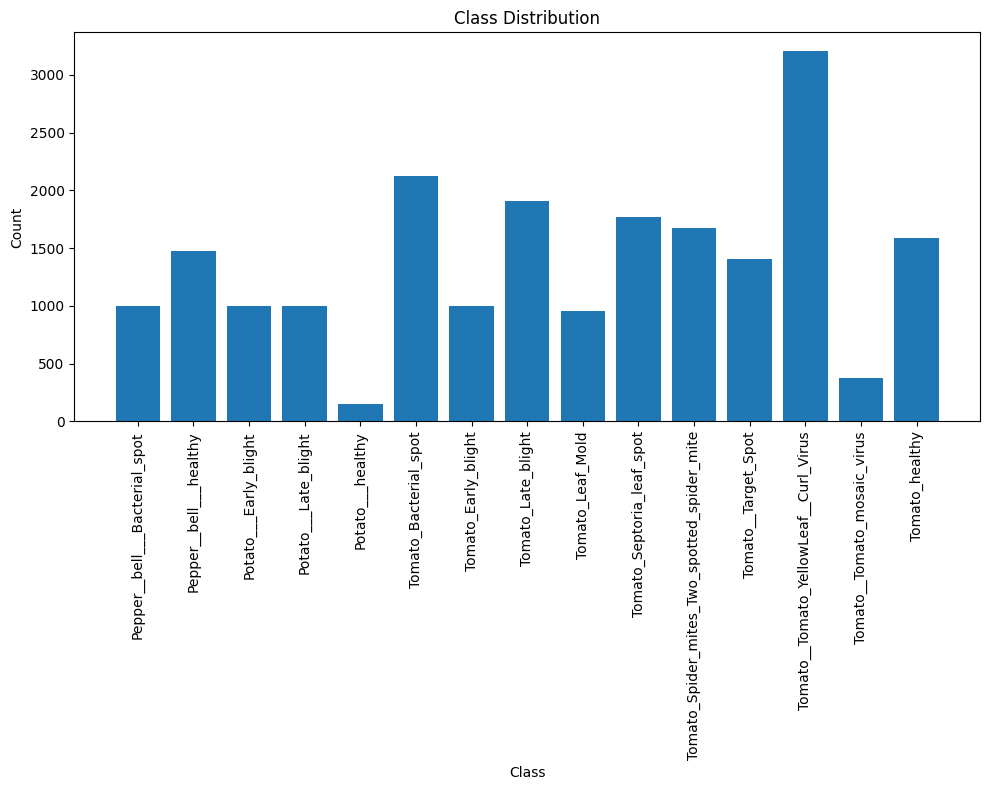

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

label_counts = Counter(train_dataset.targets)
print(label_counts)

plt.figure(figsize=(10, 8))
plt.bar(train_dataset.classes, label_counts.values())
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## 4. 클래스 불균형 처리 (WeightedRandomSampler)

In [ ]:
from torch.utils.data import WeightedRandomSampler, DataLoader

class_sample_counts = [label_counts[i] for i in range(len(train_dataset.classes))]
class_weights = [1.0 / count for count in class_sample_counts]

train_targets = [train_dataset.targets[i] for i in train_set.indices]
sample_weights = [class_weights[label] for label in train_targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_set), replacement=True)

train_loader = DataLoader(train_set, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


## 5. 모델 구성 (ResNet18 fine-tuning)

In [ ]:
from torchvision import models
import torch.nn as nn

model = models.resnet18(pretrained=True)
for name, param in model.named_parameters():
    param.requires_grad = False
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True

model.fc = nn.Linear(512, len(train_dataset.classes))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


## 6. 학습 설정

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


## 7. 학습 루프 (EarlyStopping 포함)

In [ ]:
epochs = 30
best_val_loss = np.inf
best_epoch = 0
patience = 7
counter = 0
train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_epoch = epoch
    counter = 0
    torch.save(model.state_dict(), "best_model.pth")
    print("✔️ 성능 향상! 모델 저장됨.")
  else:
    counter += 1
    print(f"⚠️ 성능 향상 없음. {counter}회 연속.")
    if counter >= patience:
        print("⛔ Early Stopping 발동!")
        break
  accuracy = correct / total
  print(f"Epoch {epoch+1} | Train Loss: {running_loss / len(train_loader):.4f} | Val Loss: {val_loss / len(val_loader):.4f} | Val Accuracy: {accuracy * 100:.2f}%")
  print(f"🎯 Best Validation Loss at Epoch {best_epoch + 1}")
  train_losses.append(running_loss / len(train_loader))
  val_losses.append(val_loss / len(val_loader))
  val_accuracies.append(accuracy * 100)

## 8. 학습 결과 시각화 (Loss & Accuracy)

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.show()

## 9. 테스트 성능 평가

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"\n🧪 Test Accuracy: {correct / total * 100:.2f}%")


## 10. Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 11. 클래스별 정확도 정리

In [ ]:
actual_counts = cm.sum(axis=1)
correct_counts = cm.diagonal()

for i, class_name in enumerate(full_dataset.classes):
    total = actual_counts[i]
    correct = correct_counts[i]
    acc = correct / total if total > 0 else 0
    print(f"{class_name:40s} | 맞춘 개수: {correct:3d} / {total:3d} | 정확도: {acc*100:.2f}%")


## 12. 프로젝트 회고

- 데이터 전처리 및 증강이 성능 향상에 기여함  
- 클래스 불균형 처리로 모델이 소수 클래스도 학습 가능  
- EarlyStopping으로 과적합 방지
